In [26]:
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.figure
import importlib, os, sys, h5py
import rcnn

# Faster RCNN for Face Detection

In this notebook, we take a look at how the faster RCNN object detector works, on a small example taken from the WIDER FACE dataset. We train our object detector on one image, and explore the structure and algorithms used to build this object detector. 

### Looking at the data and some utility functions

Utility function for visualizing images with bounding box rectangles:

In [27]:
def show_image_with_rectangles(image,rects):
    fig=plt.figure(figsize=(7,7))
    plt.imshow(image)
    for rect in rects:
        x = rect[0]+np.array([-rect[2]/2,rect[2]/2])
        y = rect[1]+np.array([-rect[3]/2,rect[3]/2])
        plt.plot(x,y[0]*np.ones(2),'c-',linewidth=3)
        plt.plot(x,y[1]*np.ones(2),'c-',linewidth=3)
        plt.plot(x[0]*np.ones(2),y,'c-',linewidth=3)
        plt.plot(x[1]*np.ones(2),y,'c-',linewidth=3)

Taking a look at the data:

In [28]:
with h5py.File('data.hdf5','r') as f:
    features = f['features'][:]
    rects = f['rects'][:]
    targets = f['targets'][:]
    anchors = f['anchors'][:]
with h5py.File('images.hdf5','r') as f:
    images = f['images'][:]
print('The input to the neural net are the features, whose shape is',features.shape)
print('The neural net target output is target, whose shape is',targets.shape)
print('The images are available if we want to look at them, their shape is ',images.shape)
print('The original WIDER rectangle definitions, too.  Their shape is',rects.shape)

The input to the neural net are the features, whose shape is (50, 8, 8, 512)
The neural net target output is target, whose shape is (50, 8, 8, 9, 5)
The images are available if we want to look at them, their shape is  (50, 224, 224, 3)
The original WIDER rectangle definitions, too.  Their shape is (50, 10, 10)


With this information, we can see what the neural net will use to train:

* `features` (50, 224, 224, 3), which has 50 RGB images, 224x224 pixels. The features were pre-computed by a CNN from the images. Here, we'll just train a CNN to detect faces.

* `targets` (50, 8, 8, 9, 5), which have, for each of the 50 images, 9 rectangles (defined by 4 points and whether or not they have a face in them), centered at the 8x8 max-pooled pixel locations.

The faster R-CNN algorithm implemented [here](https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf) uses two layers, a 3x3 convolutional layer with $N_C = 512$ inputs and a 1x1 convolutional layer with $N_D = 128$ inputs. 


In more detail, our two layers are:
1. A $3\times 3$ convolutional layer, with $N_C=512$ input channels, thus

$$\xi^{(1)}[n_1,n_2,d] = \sum_{c=0}^{N_C-1}\sum_{m_1=-1}^{1}\sum_{m_2=-1}^{1}w^{(1)}[m_1,m_2,c,d]x[n_1-m_1,n_2-m_2,c]$$
$$h[n_1,n_2,d]=\mbox{ReLU}\left(\xi^{(1)}[n_1,n_2,d]\right),$$

2. A $1\times 1$ convolution, with $N_D=128$ input channels, and $N_A\times N_Y$ outputs.  The $N_A\times N_Y$ outputs match the last two dimensions of the `target` array: they correspond to $N_A$ anchor rectangles ($a$) per position, with $N_Y$ outputs per anchor rectangle, thus:

$$\xi^{(2)}[n_1,n_2,a,k]=\sum_d w^{(2)}[0,0,d,a,k]h[n_1,n_2,d]$$


So, our first convolutional layer should have shape (3,3,512,128) (3x3 convolution, 512 inputs, 128 outputs), and our second layer should have shape (1,1,128,9,5) (1x1 convolution, 128 inputs, 9 anchor rectangles, and 5 as the shape of our output).

In [29]:
# Set initial weights
with h5py.File('weights_initial.hdf5','r') as f:
    W1=f['W1'][:]
    W2=f['W2'][:]

print('W1 has shape',W1.shape)
print('W2 has shape',W2.shape)

W1 has shape (3, 3, 512, 128)
W2 has shape (1, 1, 128, 9, 5)


Visualizing the random weights:

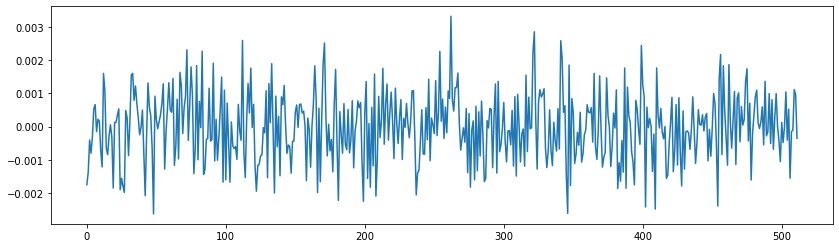

In [30]:
fig = plt.figure(figsize=(14,4))
plt.plot(np.arange(512),W1[0,0,:,0])

If we plot an example image with its reference rectangles:

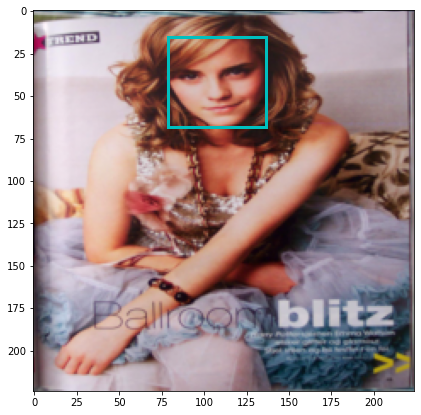

In [31]:
show_image_with_rectangles(images[1,:,:,:]/255,rects[1,:,:])

The anchors are our anchor rectangles, which are the same for all images. There are 9 anchors for each of the center 8x8 pixel locations with x, y, width, and height, so the `anchors` array is (8,8,9,4). If we take a look at the 0th rectangle for all positions:

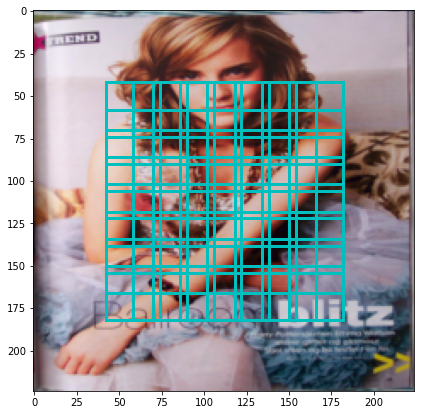

In [46]:
show_image_with_rectangles(images[1,:,:,:],anchors[:,:,1,:].reshape((8*8,4)))

And if we were to take a look at all the different sizes (small, med, large) of the rectangles, with different aspect ratios (wide, square, tall):

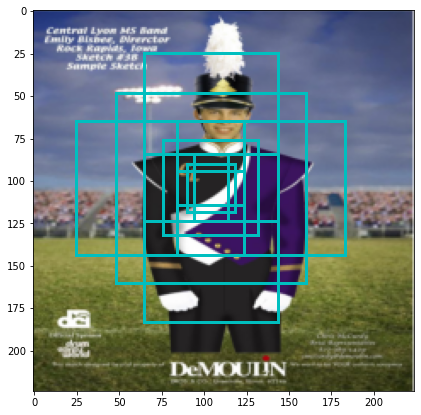

In [47]:
show_image_with_rectangles(images[0,:,:,:],anchors[3,3,:,:])

`targets` are coded as in the following [paper](https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf), so the following function decodes that.

The binary classification for anchor a at position (x,y) in image i is coded as `targets[i,x,y,a,4]`, and the regression target is coded as `targets[i,x,y,a,0:4]`.

In [33]:
def target2rect(regression_target, anchor):
    rect = np.zeros(4)
    rect[0] = regression_target[0]*anchor[2]+anchor[0]
    rect[1] = regression_target[1]*anchor[3]+anchor[1]
    rect[2] = np.exp(min(np.log(2),regression_target[2]))*anchor[2]
    rect[3] = np.exp(min(np.log(2),regression_target[3]))*anchor[3]
    return(rect)

Faster RCNN creates a target rectangle whenever a referecne and anchor have IoU > 0.7, so we get a lot more target rectangles than reference. We can actually see that there are multiple copies of the same rectangle:

In [34]:
target_rects = []
for n1 in range(8): # 8 positions in N1
    for n2 in range(8): # 8 positions in N2
        for a  in range(9): # 9 anchors per position
            if targets[0,n1,n2,a,4]==1:
                rect = target2rect(targets[0,n1,n2,a,0:4],anchors[n1,n2,a,:])
                target_rects.append(rect)
                print('x=%d, y=%d, a=%d, target (%2.2f,%2.2f,%2.2f,%2.2f)'%(n1,n2,a,*targets[0,n1,n2,a,0:4]),
                        'becomes rect (%2.2f,%2.2f,%2.2f,%2.2f)'%(rect[0],rect[1],rect[2],rect[3]))
print('There are %d target rectangles for this image'%(len(target_rects)))

x=0, y=4, a=0, target (2.81,-1.38,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=4, a=1, target (1.98,-1.95,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=5, a=1, target (1.98,-2.52,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=5, a=2, target (1.40,-3.56,-0.39,0.20) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=6, a=2, target (1.40,-4.37,-0.39,0.20) becomes rect (111.56,65.42,26.69,24.10)
x=0, y=7, a=2, target (1.40,-5.18,-0.39,0.20) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=4, a=0, target (2.00,-1.38,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=5, a=0, target (2.00,-1.78,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=6, a=0, target (2.00,-2.19,0.30,-0.50) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=6, a=1, target (1.41,-3.09,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=1, y=7, a=1, target (1.41,-3.66,-0.05,-0.15) becomes rect (111.56,65.42,26.69,24.10)
x=6, y=5, a=0, target (-2.04,-1.78,0.30,-0.50) bec

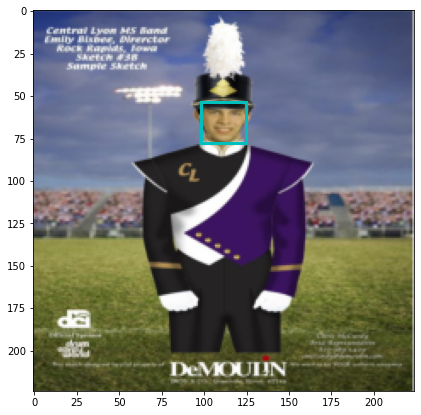

In [35]:
show_image_with_rectangles(images[0,:,:,:],target_rects)

### forwardprop

Here, we computer forward propagation through the faster RCNN network. We input a feature for each inopput image, and the feature came from another pre-trained image classifier (VGG16). Forward prop is just as described above, 

1. A $3\times 3$ convolutional layer, with $N_C=512$ input channels, thus

$$\xi^{(1)}[n_1,n_2,d] = \sum_{c=0}^{N_C-1}\sum_{m_1=-1}^{1}\sum_{m_2=-1}^{1}w^{(1)}[m_1,m_2,c,d]x[n_1-m_1,n_2-m_2,c]$$
$$h[n_1,n_2,d]=\mbox{ReLU}\left(\xi^{(1)}[n_1,n_2,d]\right),$$

2. A $1\times 1$ convolution, with $N_D=128$ input channels, and $N_A\times N_Y$ outputs.  The $N_A\times N_Y$ outputs match the last two dimensions of the `target` array: they correspond to $N_A$ anchor rectangles ($a$) per position, with $N_Y$ outputs per anchor rectangle, thus:

$$\xi^{(2)}[n_1,n_2,a,k]=\sum_d w^{(2)}[0,0,d,a,k]h[n_1,n_2,d]$$

Then, for every image i at pixels (n1, n2), and for every anchor, we then want to perform classification and regression. The classification is just the 5th element, using a sigmoid function, and the regression is just the excitation of the second layer:

$$\hat{y}[n_1,n_2,a,4] = \sigma\left(\xi^{(2)}[n_1,n_2,a,4]\right)$$
$$\hat{y}[n_1,n_2,a,0:4] = \xi^{(2)}[n_1,n_2,a,0:4]$$

In [36]:
import time
print('Time before one image forwardprop is',time.perf_counter())
H, Yhat = rcnn.forwardprop(features[0,:,:,:], W1, W2)
print('H  has the shape',H.shape,'and Yhat has the shape',Yhat.shape)
print('Time after one image forwardpropr is',time.perf_counter())

Time before one image forwardprop is 365.1748922
H  has the shape (8, 8, 128) and Yhat has the shape (8, 8, 9, 5)
Time after one image forwardpropr is 376.8708189


### Detect

Here, we want to take the output of forwardprop and detect rectangles that we think have faces. We just want to find the anchors that we think are the most probable to have faces, and can plot these on the image. These won't work very well, since our weights are just random at this stage:

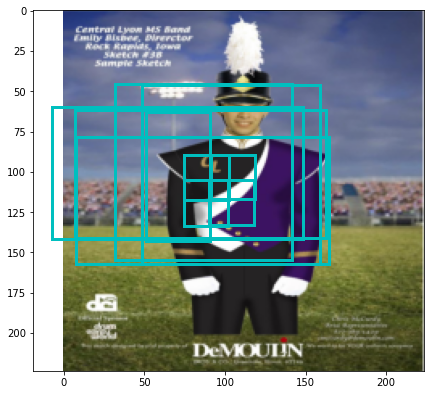

In [37]:
best_rects = rcnn.detect(Yhat, 10, anchors)
show_image_with_rectangles(images[0,:,:,:],best_rects)

### Loss

Loss for faster RCNN is the sum of MSE and BCE loss:
$${\mathcal L} = {\mathcal L}_{MSE} + {\mathcal L}_{BCE}$$  

MSE loss: Average squared difference between regression target and regression output, over only where the rectangle actually contains a face (our y vector at that n1, n2, a, 4 = 1).

$${\mathcal L}_{MSE} = \frac{1}{2}
\frac{\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{a=0}^{N_A-1} y[n_1,n_2,a,4]\times\Vert y[n_1,n_2,a,0:4]-\hat{y}[n_1,n_2,a,0:4]\Vert^2}
{\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{a=0}^{N_A-1}y[n_1,n_2,a,4]}
$$

BCE loss: Binary cross entropy loss for the classification output>

$${\mathcal L}_{BCE}=-\frac{1}{N_1N_2N_A}\sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}\sum_{a=0}^{N_A-1}y[n_1,n_2,a,4]\ln\hat{y}[n_1,n_2,a,4]+(1-y[n_1,n_2,a,4])\ln(1-\hat{y}[n_1,n_2,a,4])$$


In [48]:
bce_loss, mse_loss = rcnn.loss(Yhat, targets[0,:,:,:,:])
print('BCE loss for this image is %g, MSE loss is %g'%(bce_loss, mse_loss))

BCE loss for this image is 0.695076, MSE loss is 5.8094


### Backprop

We'll use the above loss to visualize our loss going down at the end, but what we actually need is the derivative of the loss:

$$\nabla_\xi{\mathcal L}[n_1,n_2,a,k]=\frac{d{\mathcal L}}{d\xi[n_1,n_2,a,k]}$$

where $\xi[n_1,n_2,a,k]$ is the excitation (before the sigmoid nonlinearity) at that anchor at that position.

In [39]:
GradXi1, GradXi2 = rcnn.backprop(targets[0,:,:,:,:],Yhat,H,W2)

Text(0.5, 1.0, '$∇_ξ^{(2)}L[n_1,n_2,:]$ loss gradient')

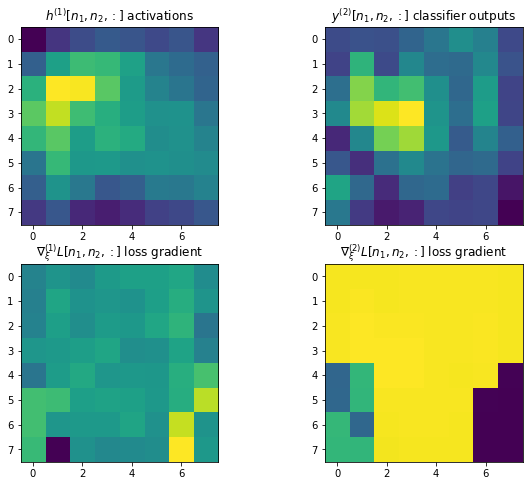

In [40]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(np.average(H,axis=2).T)
ax[0,0].set_title('$h^{(1)}[n_1,n_2,:]$ activations')
ax[1,0].imshow(np.average(GradXi1,axis=2).T)
ax[1,0].set_title('$∇_ξ^{(1)}L[n_1,n_2,:]$ loss gradient')
ax[0,1].imshow(np.average(Yhat[:,:,:,4],axis=2).T)
ax[0,1].set_title('$y^{(2)}[n_1,n_2,:]$ classifier outputs')
ax[1,1].imshow(np.average(GradXi2[:,:,:,4],axis=2).T)
ax[1,1].set_title('$∇_ξ^{(2)}L[n_1,n_2,:]$ loss gradient')


### Weight Gradient

The weight gradient is found by takin the gradient of the loss with respect to a layer's output, multiplied by inputs:

$$\nabla_{W^{(1)}}{\mathcal L}[m_1,m_2,c,d]=\sum_{n_1}\sum_{n_2}\nabla_{\xi^{(1)}}{\mathcal L}[n_1-m_1,n_2-m_2,d]x[n_1,n_2,c],~~-1\le m_1\le 1,-1\le m_2\le 1$$

$$\nabla_{W^{(2)}}{\mathcal L}[0,0,d,a,k]=\sum_{n_1}\sum_{n_2}\nabla_{\xi^{(2)}}{\mathcal L}[n_1,n_2,a,k]h[n_1,n_2,d]$$

In [49]:
dW1,dW2 = rcnn.weight_gradient(features[0,:,:,:],H,GradXi1,GradXi2,3,3)

Text(0.5, 0, 'hidden node number $d$')

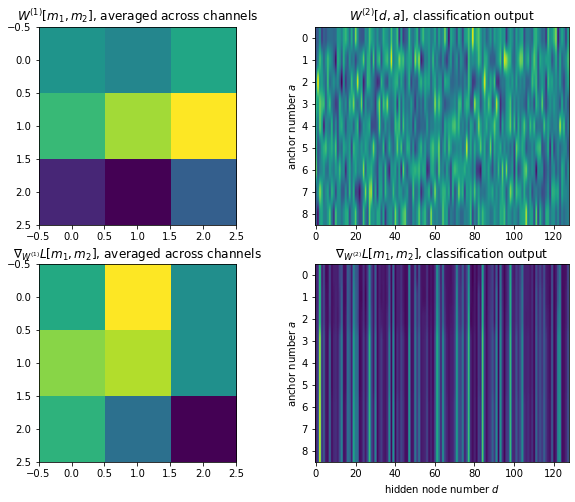

In [42]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(np.average(W1,axis=(2,3)).T)
ax[0,0].set_title('$W^{(1)}[m_1,m_2]$, averaged across channels')
ax[1,0].imshow(np.average(dW1,axis=(2,3)).T)
ax[1,0].set_title('$∇_{W^{(1)}}L[m_1,m_2]$, averaged across channels')
ax[0,1].imshow(W2[0,0,:,:,4].T,aspect='auto')
ax[0,1].set_title('$W^{(2)}[d,a]$, classification output')
ax[0,1].set_ylabel('anchor number $a$')
ax[1,1].imshow(dW2[0,0,:,:,4].T,aspect='auto')
ax[1,1].set_title('$∇_{W^{(2)}}L[m_1,m_2]$, classification output')
ax[1,1].set_ylabel('anchor number $a$')
ax[1,1].set_xlabel('hidden node number $d$')

### Weight Update

We want to move in the direction of the negative gradient, at a certain learning rate:

$$W^{(1)}[m_1,m_2,c,d] = W^{(1)}[m_1,m_2,c,d]-\eta\nabla_{W^{(1)}}{\mathcal L}[m_1,m_2,c,d]$$

$$W^{(2)}[0,0,d,a,k]=W^{(2)}[0,0,d,a,k]-\eta\nabla_{W^{(2)}}{\mathcal L}[0,0,d,a,k]$$

In [43]:
new_W1, new_W2 = rcnn.weight_update(W1,W2,dW1,dW2,0.0001)

Text(0.5, 0, 'hidden node number $d$')

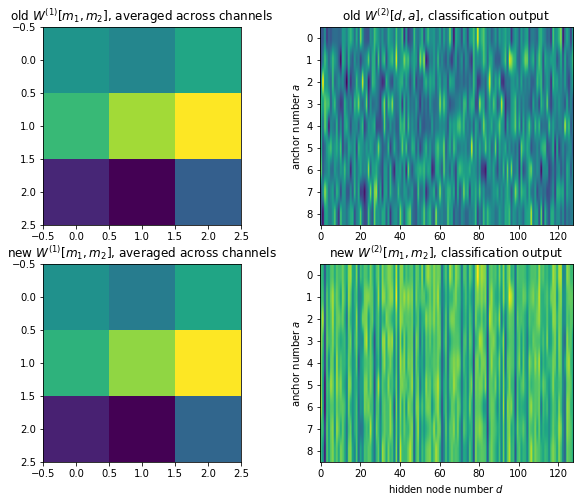

In [44]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0,0].imshow(np.average(W1,axis=(2,3)).T)
ax[0,0].set_title('old $W^{(1)}[m_1,m_2]$, averaged across channels')
ax[1,0].imshow(np.average(new_W1,axis=(2,3)).T)
ax[1,0].set_title('new $W^{(1)}[m_1,m_2]$, averaged across channels')
ax[0,1].imshow(W2[0,0,:,:,4].T,aspect='auto')
ax[0,1].set_title('old $W^{(2)}[d,a]$, classification output')
ax[0,1].set_ylabel('anchor number $a$')
ax[1,1].imshow(new_W2[0,0,:,:,4].T,aspect='auto')
ax[1,1].set_title('new $W^{(2)}[m_1,m_2]$, classification output')
ax[1,1].set_ylabel('anchor number $a$')
ax[1,1].set_xlabel('hidden node number $d$')

### Make sure that our loss is decreasing

Debugging is hard, so one method we can use is to try several steps forward and backward along the gradient and measure loss. We'll try different sizes of the learning rate, and plot loss as a function of step size.

In [45]:
steps_to_try = np.arange(-10,11)/10000
bce_losses = np.zeros(steps_to_try.shape)
mse_losses = np.zeros(steps_to_try.shape)
for t,stepsize in enumerate(steps_to_try):
    W1_tmp, W2_tmp = rcnn.weight_update(W1,W2,dW1,dW2,stepsize)
    H_tmp, Yhat_tmp = rcnn.forwardprop(features[0,:,:,:], W1_tmp, W2_tmp)
    bce_losses[t], mse_losses[t] = rcnn.loss(Yhat_tmp, targets[0,:,:,:,:])
    print('Step %d (step %g): bce_loss=%g, mse_loss=%g'%(t,stepsize,bce_losses[t],mse_losses[t]))

Step 0 (step -0.001): bce_loss=-0, mse_loss=28417.8
Step 1 (step -0.0009): bce_loss=-0, mse_loss=18815
Step 2 (step -0.0008): bce_loss=-0, mse_loss=11888.6
Step 3 (step -0.0007): bce_loss=0.0625758, mse_loss=7085.96
Step 4 (step -0.0006): bce_loss=0.43611, mse_loss=3918.5
Step 5 (step -0.0005): bce_loss=1.39533, mse_loss=1962.11
Step 6 (step -0.0004): bce_loss=6.7684, mse_loss=857.044
Step 7 (step -0.0003): bce_loss=14.1277, mse_loss=307.821
Step 8 (step -0.0002): bce_loss=13.6698, mse_loss=83.3442
Step 9 (step -0.0001): bce_loss=3.71005, mse_loss=16.8123
Step 10 (step 0): bce_loss=0.695076, mse_loss=5.8094
Step 11 (step 0.0001): bce_loss=0.220034, mse_loss=2.85048
Step 12 (step 0.0002): bce_loss=0.394649, mse_loss=9.11563
Step 13 (step 0.0003): bce_loss=0.852814, mse_loss=62.7603
Step 14 (step 0.0004): bce_loss=1.49357, mse_loss=226.074
Step 15 (step 0.0005): bce_loss=2.31297, mse_loss=585.43
Step 16 (step 0.0006): bce_loss=3.31087, mse_loss=1251.33
Step 17 (step 0.0007): bce_loss=3.1

Text(0.5, 1.0, 'MSE loss as a function of step size in negative-weight-gradient direction')

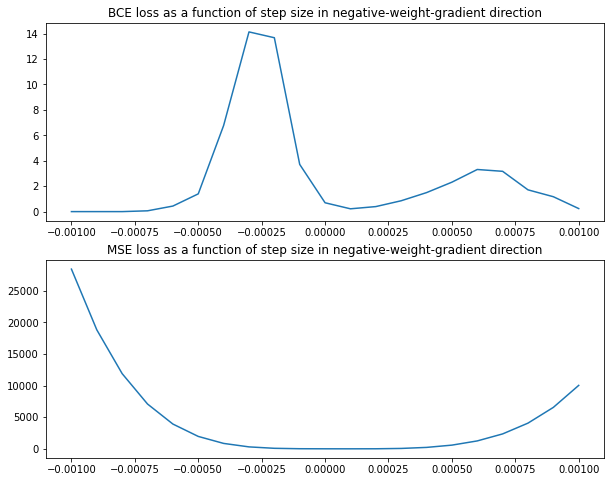

In [50]:
fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(steps_to_try,bce_losses)
ax[0].set_title('BCE loss as a function of step size in negative-weight-gradient direction')
ax[1].plot(steps_to_try,mse_losses)
ax[1].set_title('MSE loss as a function of step size in negative-weight-gradient direction')


As we can see, small positive step sizes (up to a certain optimal point) show that we are decreasing our loss, so we seem to be going in the right direction.

### Conclusion

You probably noticed that this notebook only performs one step on one image of a small dataset - if we were to actually train a faster RCNN object detector, we'd want to train on many more images, for many more epochs, using PyTorch and some more optimizers. This notebook just serves to show how the main steps occuring in the background work, including forward propagation, backprop, weight gradients, and weight updates.